In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
'''
zip_path = "/content/drive/MyDrive/7015/archive.zip"
extract_path = "/content/drive/MyDrive/7015/vqa_rad"  # vqa_rad dataset extract to Drive

import zipfile
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("It has been decompressed to Google Drive and will be permanently saved.")
'''

'\nzip_path = "/content/drive/MyDrive/7015/archive.zip"\nextract_path = "/content/drive/MyDrive/7015/vqa_rad"  # vqa_rad dataset extract to Drive\n\nimport zipfile\nwith zipfile.ZipFile(zip_path, \'r\') as z:\n    z.extractall(extract_path)\n\nprint("It has been decompressed to Google Drive and will be permanently saved.")\n'

In [ ]:
import os

root = "/content/drive/MyDrive/7015/vqa_rad"
for item in os.listdir(root):
    print(item)


VQA_RAD Image Folder
processed
Readme.docx
VQA_RAD Dataset Public.xlsx
VQA_RAD Dataset Public.json
VQA_RAD Dataset Public.xml
.ipynb_checkpoints
cnn_lstm_history.pkl
cnn_lstm_model.pth
cnn_lstm_model_second.pth
cnn_lstm_history2.pkl
cnn_lstm_model_final.pth
cnn_lstm_history4.pkl
BLIP
blip_finetune


In [ ]:
import json

json_path = "/content/drive/MyDrive/7015/vqa_rad/VQA_RAD Dataset Public.json"

with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print("Total entries:", len(data))
print("One sample looks like:\n")
print(data[0])


Total entries: 2248
One sample looks like:

{'qid': '0', 'phrase_type': 'freeform', 'qid_linked_id': '03f451ca-de62-4617-9679-e836026a7642', 'image_case_url': 'https://medpix.nlm.nih.gov/case?id=48e1dd0e-8552-46ad-a354-5eb55be86de6', 'image_name': 'synpic54610.jpg', 'image_organ': 'HEAD', 'evaluation': 'not evaluated', 'question': 'Are regions of the brain infarcted?', 'question_rephrase': 'NULL', 'question_relation': 'NULL', 'question_frame': 'NULL', 'question_type': 'PRES', 'answer': 'Yes', 'answer_type': 'CLOSED'}


In [ ]:
PROC = os.path.join(root, 'processed')


In [ ]:
topk_info = json.load(open(os.path.join(PROC, "topK_info.json"), "r"))
LABELS = topk_info["topK"]
label2id = {a:i for i,a in enumerate(LABELS)}
id2label = {i:a for a,i in label2id.items()}


In [ ]:


import json, os, random, collections
from pathlib import Path

random.seed(42)

ROOT = "/content/drive/MyDrive/7015/vqa_rad"
JSON_PATH = os.path.join(ROOT, "VQA_RAD Dataset Public.json")
IMAGE_FOLDER = os.path.join(ROOT, "VQA_RAD Image Folder")

OUT_DIR = os.path.join(ROOT, "processed")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# --------------------------------------------------------
# 1. Load raw VQA-RAD JSON file
# --------------------------------------------------------
with open(JSON_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

print("Total entries:", len(data))
print("Example keys:", list(data[0].keys()))
print("Example sample:", data[0])

# --------------------------------------------------------
# 2. Normalize answers & questions, check image file existence
# --------------------------------------------------------
for i, item in enumerate(data):

    # Normalize answer
    item['answer_raw'] = item.get('answer', None)
    if item['answer_raw'] is None:
        item['answer'] = ""
    else:
        item['answer'] = str(item['answer_raw']).strip().lower()  # lowercase normalization

    # Normalize question text
    item['question'] = str(item.get('question', '')).strip()

    # Assign image file name (e.g., 'synpic54610.jpg')
    item['image_file'] = item.get('image_name')

    # Check if the corresponding image exists
    img_path = os.path.join(IMAGE_FOLDER, item['image_file'])
    item['image_exists'] = os.path.exists(img_path)

# Count missing images for reporting
missing = sum(1 for x in data if not x['image_exists'])
print(f"Missing images: {missing} / {len(data)}  (These samples can be removed or fixed later)")

# --------------------------------------------------------
# 3. Count answer frequencies BEFORE splitting
# --------------------------------------------------------
ans_freq = collections.Counter(x['answer'] for x in data if x['answer'])
print("Top 30 answers (overall):")
for a, c in ans_freq.most_common(30):
    print(a, c)

# --------------------------------------------------------
# 4. Randomly split dataset into 70% train, 10% val, 20% test
# --------------------------------------------------------
indices = list(range(len(data)))
random.shuffle(indices)

n = len(indices)
n_train = int(0.7 * n)
n_val   = int(0.1 * n)

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train + n_val]
test_idx  = indices[n_train + n_val:]

train = [data[i] for i in train_idx]
val   = [data[i] for i in val_idx]
test  = [data[i] for i in test_idx]

print("Split sizes -> train, val, test:", len(train), len(val), len(test))

# Save the splits as JSON files
def save_json(obj, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

save_json(train, os.path.join(OUT_DIR, "train.json"))
save_json(val,   os.path.join(OUT_DIR, "val.json"))
save_json(test,  os.path.join(OUT_DIR, "test.json"))
print("Saved train/val/test JSON files to:", OUT_DIR)

# --------------------------------------------------------
# 5. For baseline (CNN+LSTM): select Top-K most frequent answers
# --------------------------------------------------------
K = 50  # Common choices: 50 or 100
train_ans_freq = collections.Counter(x['answer'] for x in train if x['answer'])
topK = [a for a, c in train_ans_freq.most_common(K)]
print(f"TopK chosen (K={K}):", topK)

# Filter samples: keep only samples whose answers belong to Top-K,
# and ensure images exist and questions are non-empty.
train_filtered = [x for x in train if x['answer'] in topK and x['image_exists'] and x['question']]
val_filtered   = [x for x in val   if x['answer'] in topK and x['image_exists'] and x['question']]
test_filtered  = [x for x in test  if x['answer'] in topK and x['image_exists'] and x['question']]

print(
    "Filtered sizes (TopK answers only & valid images/question) -> "
    f"train: {len(train_filtered)}, val: {len(val_filtered)}, test: {len(test_filtered)}"
)

# Save filtered files and topK info
save_json({"topK": topK, "K": K}, os.path.join(OUT_DIR, "topK_info.json"))
save_json(train_filtered, os.path.join(OUT_DIR, "train_filtered.json"))
save_json(val_filtered,   os.path.join(OUT_DIR, "val_filtered.json"))
save_json(test_filtered,  os.path.join(OUT_DIR, "test_filtered.json"))
print("Saved filtered splits for baseline training.")

# --------------------------------------------------------
# 6. Prepare CSV files for BLIP training/evaluation
# Columns: (image_path, question, answer)
# --------------------------------------------------------
import csv

def write_csv(data_list, out_csv):
    with open(out_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["image_path", "question", "answer"])
        for it in data_list:
            img = os.path.join(IMAGE_FOLDER, it['image_file'])
            writer.writerow([img, it['question'], it['answer']])

write_csv(train, os.path.join(OUT_DIR, "train_blip.csv"))
write_csv(val,   os.path.join(OUT_DIR, "val_blip.csv"))
write_csv(test,  os.path.join(OUT_DIR, "test_blip.csv"))
print("Saved BLIP CSV files to:", OUT_DIR)



Total entries: 2248
Example keys: ['qid', 'phrase_type', 'qid_linked_id', 'image_case_url', 'image_name', 'image_organ', 'evaluation', 'question', 'question_rephrase', 'question_relation', 'question_frame', 'question_type', 'answer', 'answer_type']
Example sample: {'qid': '0', 'phrase_type': 'freeform', 'qid_linked_id': '03f451ca-de62-4617-9679-e836026a7642', 'image_case_url': 'https://medpix.nlm.nih.gov/case?id=48e1dd0e-8552-46ad-a354-5eb55be86de6', 'image_name': 'synpic54610.jpg', 'image_organ': 'HEAD', 'evaluation': 'not evaluated', 'question': 'Are regions of the brain infarcted?', 'question_rephrase': 'NULL', 'question_relation': 'NULL', 'question_frame': 'NULL', 'question_type': 'PRES', 'answer': 'Yes', 'answer_type': 'CLOSED'}
Missing images: 0 / 2248  (These samples can be removed or fixed later)
Top 30 answers (overall):
no 606
yes 587
axial 43
right 26
left 19
pa 15
ct 13
brain 13
fat 9
one 8
x-ray 8
right side 8
mri 8
diffuse 7
right upper lobe 7
bilateral 7
right lung 7
wit

In [ ]:
# 1) missing images and split sizes
import json, os
p="/content/drive/MyDrive/7015/vqa_rad/processed"
for f in ["train.json","val.json","test.json","train_filtered.json","val_filtered.json","test_filtered.json"]:
    arr=json.load(open(os.path.join(p,f),'r',encoding='utf-8'))
    print(f, len(arr))
# check missing images from original json (if you didn't print earlier)
data=json.load(open("/content/drive/MyDrive/7015/vqa_rad/VQA_RAD Dataset Public.json",'r',encoding='utf-8'))
missing=sum(1 for x in data if not os.path.exists(os.path.join("/content/drive/MyDrive/7015/vqa_rad/VQA_RAD Image Folder", x.get('image_name'))))
print("missing images:", missing)


train.json 1573
val.json 224
test.json 451
train_filtered.json 1092
val_filtered.json 142
test_filtered.json 300
missing images: 0


CNN

In [ ]:
# ============================================================
# Preliminary CNN Baseline
# Metrics: Train Loss, Val Accuracy, Macro F1, Weighted F1
# ============================================================

import os, json, random, torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
ROOT = "/content/drive/MyDrive/7015/vqa_rad"
IMAGE_FOLDER = os.path.join(ROOT, "VQA_RAD Image Folder")
PROC = os.path.join(ROOT, "processed")
train_json = os.path.join(PROC, "train_filtered.json")
val_json   = os.path.join(PROC, "val_filtered.json")

# ------------------------------------------------------------
# Dataset
# ------------------------------------------------------------
class SimpleVQADataset(Dataset):
    def __init__(self, json_path, image_folder, transform=None):
        self.items = json.load(open(json_path, 'r', encoding='utf-8'))
        self.image_folder = image_folder
        self.transform = transform

        # build label space (Top-K answers already filtered)
        self.labels = LABELS
        self.label2id = label2id


    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img_path = os.path.join(self.image_folder, it['image_file'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.label2id[it['answer']]
        return img, label, it['question']

# ------------------------------------------------------------
# Transforms
# ------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# ------------------------------------------------------------
# DataLoaders
# ------------------------------------------------------------
train_ds = SimpleVQADataset(train_json, IMAGE_FOLDER, transform)
val_ds   = SimpleVQADataset(val_json, IMAGE_FOLDER, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

# ------------------------------------------------------------
# Model
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_ds.labels)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------------------------------------------------
# Training + Validation
# ------------------------------------------------------------
train_losses = []
val_accuracies = []
macro_f1s = []
weighted_f1s = []
final_f1_macro = None
final_f1_weighted = None

EPOCHS = 5

for epoch in range(EPOCHS):

    # ========================
    # Train
    # ========================
    model.train()
    running_loss = 0.0

    for imgs, labels, _ in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    avg_loss = running_loss / len(train_ds)
    train_losses.append(avg_loss)

    # ========================
    # Validation
    # ========================
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    val_acc = correct / total
    val_accuracies.append(val_acc)

    # ========================
    # F1 score
    # ========================
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")

    # Store the F1 of each epoch
    macro_f1s.append(f1_macro)
    weighted_f1s.append(f1_weighted)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={avg_loss:.4f}, "
        f"Val Acc={val_acc:.4f}, "
        f"Macro F1={f1_macro:.4f}, "
        f"Weighted F1={f1_weighted:.4f}"
    )

    # Record the metrics of the last epoch.
    if epoch == EPOCHS - 1:
        final_f1_macro = f1_macro
        final_f1_weighted = f1_weighted



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 85.0MB/s]


Epoch 1: Train Loss=2.9622, Val Acc=0.5211, Macro F1=0.1175, Weighted F1=0.4582
Epoch 2: Train Loss=1.5162, Val Acc=0.5352, Macro F1=0.1203, Weighted F1=0.4806
Epoch 3: Train Loss=1.1974, Val Acc=0.5070, Macro F1=0.0938, Weighted F1=0.4635
Epoch 4: Train Loss=1.0618, Val Acc=0.4718, Macro F1=0.1308, Weighted F1=0.4400
Epoch 5: Train Loss=1.0120, Val Acc=0.5141, Macro F1=0.1270, Weighted F1=0.4792


Found sample at index 4


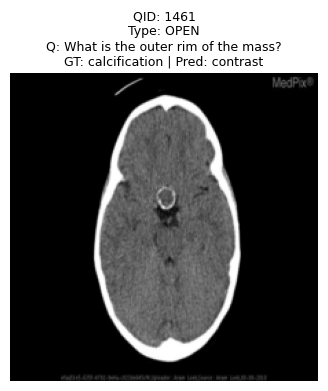

In [ ]:
from torchvision.transforms import ToPILImage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Select sample by QID
# =========================
TARGET_QID = "1461"

idx = None
for i, item in enumerate(val_ds.items):
    if str(item.get("qid")) == str(TARGET_QID):
        idx = i
        break

assert idx is not None, "QID not found in validation set"
print(f"Found sample at index {idx}")

# =========================
# Inference
# =========================
model.eval()
img, label_idx, q = val_ds[idx]
item = val_ds.items[idx]

answer_type = item.get("answer_type", "unknown")
qid = item.get("qid")

with torch.no_grad():
    out = model(img.unsqueeze(0).to(device))
    pred = out.argmax(dim=1).item()

gt = id2label[label_idx]
pred_label = id2label[pred]

# =========================
# Visualization
# =========================
img_disp = ToPILImage()(img)

plt.figure(figsize=(4,4))
plt.imshow(img_disp)
plt.axis("off")
plt.title(
    f"QID: {qid}\n"
    f"Type: {answer_type}\n"
    f"Q: {q}\n"
    f"GT: {gt} | Pred: {pred_label}",
    fontsize=9
)
plt.show()


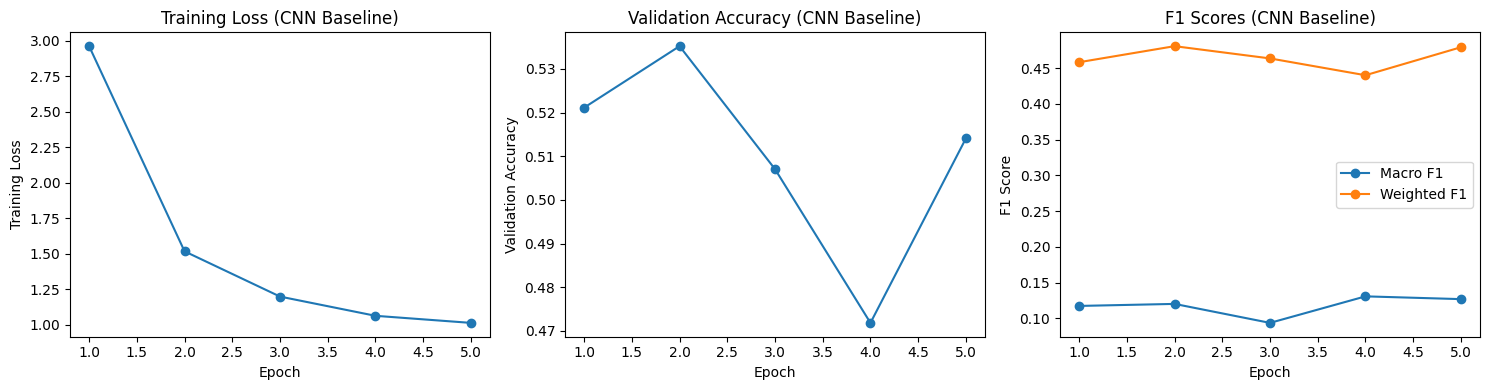

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(15,4))

# -------- Train Loss --------
plt.subplot(1,3,1)
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss (CNN Baseline)")

# -------- Validation Accuracy --------
plt.subplot(1,3,2)
plt.plot(epochs, val_accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy (CNN Baseline)")

# -------- F1 Scores --------
plt.subplot(1,3,3)
plt.plot(epochs, macro_f1s, marker='o', label="Macro F1")
plt.plot(epochs, weighted_f1s, marker='o', label="Weighted F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Scores (CNN Baseline)")
plt.legend()

plt.tight_layout()
plt.show()



BLIP

In [ ]:
# ================================
# BLIP Zero-shot VQA on VQA-RAD
# With QID + Open/Closed Annotation
# ================================

from transformers import pipeline
from PIL import Image
import os, json, csv
import matplotlib.pyplot as plt
import torch

# ---------- Paths ----------
ROOT = "/content/drive/MyDrive/7015/vqa_rad"
IMAGE_FOLDER = os.path.join(ROOT, "VQA_RAD Image Folder")
PROC = os.path.join(ROOT, "processed")

# choose which split to evaluate: train / val / test
JSON_FILE = os.path.join(PROC, "val_filtered.json")

OUT_CSV = "/content/blip_zero_shot_results.csv"
OUT_IMG_DIR = "/content/blip_visuals"
os.makedirs(OUT_IMG_DIR, exist_ok=True)

# ---------- Load BLIP pipeline ----------
device = 0 if torch.cuda.is_available() else -1
vqa = pipeline(
    "vqa",
    model="Salesforce/blip-vqa-base",
    device=device
)

# ---------- Load data ----------
items = json.load(open(JSON_FILE, "r", encoding="utf-8"))

# limit samples for quick run (set None to run all)
MAX_SAMPLES = 20
items = items[:MAX_SAMPLES]

# ---------- CSV writer ----------
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow([
        "qid",
        "answer_type",
        "image_path",
        "question",
        "gold_answer",
        "pred_answer",
        "pred_score"
    ])

    # ---------- Inference loop ----------
    for i, it in enumerate(items):
        qid = it.get("qid", "N/A")
        question = it.get("question", "").strip()
        gold = str(it.get("answer", "")).lower().strip()
        answer_type = it.get("answer_type", "UNKNOWN")
        img_name = it.get("image_file") or it.get("image_name")

        if not img_name or question == "":
            continue

        img_path = os.path.join(IMAGE_FOLDER, img_name)
        if not os.path.exists(img_path):
            continue

        image = Image.open(img_path).convert("RGB")

        # ---------- BLIP prediction ----------
        result = vqa(image, question)
        if isinstance(result, list):
            result = result[0]

        pred = result.get("answer", "")
        score = result.get("score", None)

        # ---------- Save CSV ----------
        writer.writerow([
            qid,
            answer_type,
            img_path,
            question,
            gold,
            pred,
            score
        ])

        # ---------- Visualization ----------
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(
            f"QID: {qid} | Type: {answer_type}\n"
            f"Q: {question}\n"
            f"GT: {gold} | Pred: {pred}",
            fontsize=9
        )

        out_img = os.path.join(OUT_IMG_DIR, f"blip_qid_{qid}.png")
        plt.savefig(out_img, bbox_inches="tight")
        plt.close(fig)

        if (i + 1) % 5 == 0:
            print(f"Processed {i+1}/{len(items)}")

print("✅ BLIP zero-shot inference finished")
print("CSV saved to:", OUT_CSV)
print("Visuals saved to:", OUT_IMG_DIR)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


Processed 5/20
Processed 10/20


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 15/20
Processed 20/20
✅ BLIP zero-shot inference finished
CSV saved to: /content/blip_zero_shot_results.csv
Visuals saved to: /content/blip_visuals


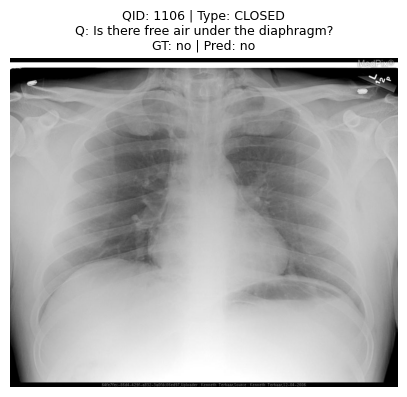

In [ ]:
TARGET_QID = 1106

item = next(it for it in items if it.get("qid") == TARGET_QID)

image = Image.open(
    os.path.join(IMAGE_FOLDER, item["image_file"])
).convert("RGB")

question = item["question"]
answer_type = item.get("answer_type", "UNKNOWN")
gold = item["answer"]

result = vqa(image, question)
result = result[0] if isinstance(result, list) else result

pred = result.get("answer", "")
score = result.get("score", None)

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis("off")
plt.title(
    f"QID: {TARGET_QID} | Type: {answer_type}\n"
    f"Q: {question}\n"
    f"GT: {gold} | Pred: {pred}",
    fontsize=9
)
plt.show()


In [ ]:
'''
from google.colab import files
files.download("/content/blip_results_with_images.html")
"""

SyntaxError: incomplete input (ipython-input-3530245763.py, line 1)

In [ ]:
'''
# Method A: create self-contained HTML with base64 images and download
import pandas as pd, os
from PIL import Image
from io import BytesIO
import base64
from google.colab import files

csv_path = "/content/blip_results.csv"   # <- 修改为你 CSV 路径
df = pd.read_csv(csv_path)

def img_to_base64_dataurl(img_path, max_w=300):
    if not os.path.exists(img_path):
        return ""
    img = Image.open(img_path).convert("RGB")
    w,h = img.size
    if w > max_w:
        r = max_w / float(w)
        img = img.resize((int(w*r), int(h*r)))
    buf = BytesIO()
    img.save(buf, format="JPEG", quality=85)
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return f"data:image/jpeg;base64,{b64}"

rows_html = []
N = min(50, len(df))  # 控制导出数量，避免文件过大
for i, row in df.head(N).iterrows():
    img_path = row['image_path']
    q = str(row.get('question',''))
    gold = str(row.get('gold_answer',''))
    pred = str(row.get('pred_answer',''))
    score = row.get('pred_score','')
    dataurl = img_to_base64_dataurl(img_path, max_w=300)
    img_tag = f'<img src="{dataurl}" style="max-width:300px;height:auto;" />' if dataurl else ''
    rows_html.append(f"<tr><td>{img_tag}</td><td>{q}</td><td>{gold}</td><td>{pred}</td><td>{score}</td></tr>")

html = f"""
<html><head><meta charset="utf-8">
<style>table{{border-collapse:collapse}} td,th{{border:1px solid #ccc;padding:6px;vertical-align:top}} img{{display:block}}</style>
</head><body>
<h3>BLIP Results (first {N} rows)</h3>
<table><tr><th>image</th><th>question</th><th>gold_answer</th><th>pred_answer</th><th>pred_score</th></tr>
{''.join(rows_html)}
</table></body></html>
"""

out = "/content/blip_results_embedded.html"
with open(out, "w", encoding="utf-8") as f:
    f.write(html)
print("Saved:", out, " filesize (KB):", round(os.path.getsize(out)/1024,2))

# trigger browser download
files.download(out)
'''

SyntaxError: incomplete input (ipython-input-819739117.py, line 53)